### Setup: Import Dependencies
Run the cell below to import the relevant dependencies.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
import functools

### Part 1: CMA-ES
Implement CMA-ES below.

In [ ]:
def cmaes(fn, dim, num_iter=10):
  """Optimizes a given function using CMA-ES.

  Args:
    fn: A function that takes as input a vector and outputs a scalar value.
    dim: (int) The dimension of the vector that fn expects as input.
    num_iter: (int) Number of iterations to run CMA-ES.

  Returns:
    mu_vec: An array of size [num_iter, dim] storing the value of mu at each
      iteration.
    best_sample_vec: A list of length [num_iter] storing the function value
      for the best sample from each iteration of CMA-ES.
    mean_sample_vec: A list of length [num_iter] storing the average function
      value across samples from each iteration of CMA-ES.
  """
  # Hyperparameters
  sigma = 10
  population_size = 100
  p_keep = 0.10  # Fraction of population to keep
  noise = 0.25  # Noise added to covariance to prevent it from going to 0.

  # Initialize the mean and covariance
  mu = np.zeros(dim)
  cov = sigma**2 * np.eye(dim)

  mu_vec = []
  best_sample_vec = []
  mean_sample_vec = []
  for t in range(num_iter):
    # WRITE CODE HERE
    mutations = np.random.multivariate_normal(mu, cov, population_size) 
    fitness_scores = np.array([fn(mutation) for mutation in mutations])
    
    num_keep = int(population_size * p_keep)
    elities_indices = np.argsort(fitness_scores)[-num_keep:]
    elities = mutations[elities_indices]
    elities_fitness = fitness_scores[elities_indices]
    mu = np.mean(elities, axis=0)
    cov = np.cov(elities, rowvar=False) + noise * np.eye(dim)

    mu_vec.append(mu)
    best_sample_vec.append(np.max(elities_fitness))
    mean_sample_vec.append(np.mean(fitness_scores))

    print(f"Generation {t+1}: Best Fitness = {best_sample_vec[-1]}")

  return mu_vec, best_sample_vec, mean_sample_vec

In the cell below, we've defined a simply function:
$$f(x) = -\|x - x^*\|_2^2 \quad \text{where} \quad x^* = [65, 49].$$
This function is optimized when $x = x^*$. Run your implementation of CMA-ES on this function, confirming that you get the correct solution.

In [28]:
def test_fn(x):
  goal = np.array([65, 49])
  return -np.sum((x - goal)**2)

mu_vec, best_sample_vec, mean_sample_vec = cmaes(test_fn, dim=2, num_iter=100)

Generation 1: Best Fitness = -2781.7929259996436
Generation 2: Best Fitness = -2902.282951368641
Generation 3: Best Fitness = -2774.6821475281467
Generation 4: Best Fitness = -2768.257971095406
Generation 5: Best Fitness = -2760.7454358874656
Generation 6: Best Fitness = -2762.941579136831
Generation 7: Best Fitness = -2761.7034166536373
Generation 8: Best Fitness = -2760.8780156440703
Generation 9: Best Fitness = -2760.805864733407
Generation 10: Best Fitness = -2760.7647613000327
Generation 11: Best Fitness = -2760.704453362059
Generation 12: Best Fitness = -2760.704831858854
Generation 13: Best Fitness = -2760.6993717513515
Generation 14: Best Fitness = -2760.699245169245
Generation 15: Best Fitness = -2760.699190585475
Generation 16: Best Fitness = -2760.6991441193813
Generation 17: Best Fitness = -2760.699128376583
Generation 18: Best Fitness = -2760.6991272552264
Generation 19: Best Fitness = -2760.699125290238
Generation 20: Best Fitness = -2760.6991244941682
Generation 21: Best

Run the following cell to visualize CMA-ES.

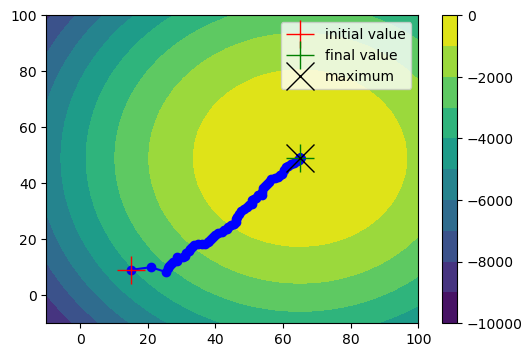

In [10]:
x = np.stack(np.meshgrid(np.linspace(-10, 100, 30), np.linspace(-10, 100, 30)), axis=-1)
fn_value = [test_fn(xx) for xx in x.reshape((-1, 2))]
fn_value = np.array(fn_value).reshape((30, 30))
plt.figure(figsize=(6, 4))
plt.contourf(x[:, :, 0], x[:, :, 1], fn_value, levels=10)
plt.colorbar()
mu_vec = np.array(mu_vec)
plt.plot(mu_vec[:, 0], mu_vec[:, 1], 'b-o')
plt.plot([mu_vec[0, 0]], [mu_vec[0, 1]], 'r+', ms=20, label='initial value')
plt.plot([mu_vec[-1, 0]], [mu_vec[-1, 1]], 'g+', ms=20, label='final value')
plt.plot([65], [49], 'kx', ms=20, label='maximum')
plt.legend()
plt.show()

Next, you will apply CMA-ES to a more complicating: maximizing the expected reward of a RL agent. The policy takes action LEFT with probability:
$$\pi(a = \text{LEFT} \mid s) = s \cdot w + b,$$
where $w \in \mathbb{R}^4$ and $b \in \mathbb{R}$ are parameters that you will optimize with CMA-ES. In the cell below, define a function that takes as input a single vector $x = (w, b)$ and the environment and returns the total (undiscounted) reward from one episode.

In [11]:
def _sigmoid(x):
  return 1 / (1 + np.exp(-x))

def _get_action(s, params):
  w = params[:4]
  b = params[4]
  p_left = _sigmoid(w @ s + b)
  a = np.random.choice(2, p=[p_left, 1 - p_left])
  return a

def rl_fn(params, env):
    assert len(params) == 5
    ## WRITE CODE HERE
    total_rewards = 0
    s, _ = env.reset()
    done = False
    while not done:
        a = _get_action(s, params)
        s, r, terminated, truncated, _ = env.step(a)
        done = terminated or truncated
        total_rewards += r
        
    return total_rewards # Return total rewards

In [19]:
# Q1.2
def eval_rl_fn(params, num_iterations):
  env = gym.make('CartPole-v1')
  total_rewards = 0
  for _ in range(num_iterations):
    total_rewards += rl_fn(params, env)
  return total_rewards / num_iterations

x1 = np.array([-1, -1, -1, -1, -1])
x2 = np.array([1, 0, 1, 0, 1])
x3 = np.array([0, 1, 2, 3, 4])


print("Eval x1:", eval_rl_fn(x1, 1000))
print("Eval x2:", eval_rl_fn(x2, 1000))
print("Eval x3:", eval_rl_fn(x3, 1000))

Eval x1: 15.732
Eval x2: 14.381
Eval x3: 9.425


The cell below applies your CMA-ES implementation to the RL objective you've defined in the cell above.

In [12]:
env = gym.make('CartPole-v0')
fn_with_env = functools.partial(rl_fn, env=env)
mu_vec, best_sample_vec, mean_sample_vec = cmaes(fn_with_env, dim=5, num_iter=10)

Generation 1: Best Fitness = 168.0
Generation 2: Best Fitness = 200.0
Generation 3: Best Fitness = 200.0
Generation 4: Best Fitness = 200.0
Generation 5: Best Fitness = 200.0
Generation 6: Best Fitness = 200.0
Generation 7: Best Fitness = 200.0
Generation 8: Best Fitness = 200.0
Generation 9: Best Fitness = 200.0
Generation 10: Best Fitness = 200.0


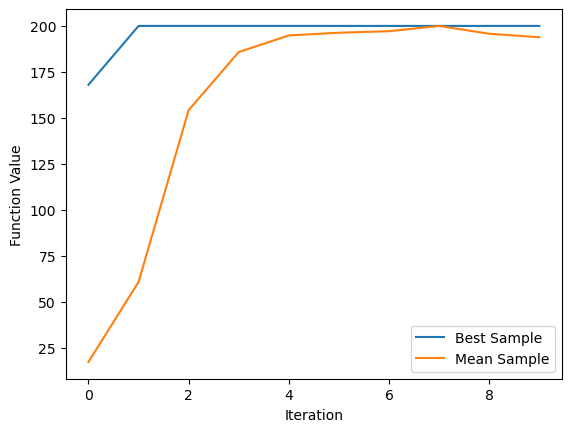

In [ ]:
#Include plot showing mean
#sample reward and best sample reward (Y axis) across iterations (X axis). Remember
#to label both lines and both axes.

plt.plot(best_sample_vec, label='Best Sample')
plt.plot(mean_sample_vec, label='Mean Sample')
plt.xlabel('Iteration')
plt.ylabel('Function Value')
plt.legend()
plt.show()

